In [1]:
import torch
import numpy as np
from tqdm import tqdm
import h5py

from torchmetrics import AUROC

import torch.nn.functional as F
import scipy.io as sio


import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import Linear

# import wandb
# import lightning as L

from torch_geometric.nn import GraphConv 
from torch_geometric.nn import GCNConv, ChebConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.nn.conv import MessagePassing

/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'triton' has no attribute 'language'

In [2]:
# Load adjacency matrix
adj = sio.loadmat('/home/data_shared/adj_mat.mat')['adj_mat']

# Create edge index and edge weight from adjacency matrix
ind = (adj != 0) & (adj != 1)
edge_index = np.argwhere(ind == True).T 
edge_weight = np.zeros((1, edge_index.shape[1]))

for i, e in enumerate(edge_index.T):  
    edge_weight[0, i] = adj[e[0], e[1]]
        
print(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Load electrode positions
pos = sio.loadmat('/home/data_shared/position.mat')['pos'].T

[[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
   6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 11 11 11 12 12
  12 13 13 13 14 14 14 15 15 15 16 16 16 16 16 17 17 17 17 18 18 18 18 18]
 [ 1  2 10 16  0  3 11 16  0  4 10 16  1  5 11 16  2  6 12 17  3  7 13 17
   4  8 14 18  5  9 15 18  6  9 14 18  7  8 15 18  0  2 12  1  3 13  4 10
  14  5 11 15  6  8 12  7  9 13  0  1  2  3 17  4  5 16 18  6  7  8  9 17]]


In [3]:
# Load EEG data and labels
with h5py.File('/home/data_shared/clip_data.h5', "r") as f:
    EEG = np.array(f[list(f.keys())[0]])

with h5py.File('/home/data_shared/label.h5', "r") as f: 
    Label = np.array(f[list(f.keys())[0]])
print(EEG.shape)

(38497, 10, 19, 200)


The EEG data looks like (N, C, T, F), where:

- N: Number of samples or trials = 30000
- C: Number of channels (electrodes i.e. nodes in the graph) = 19
- T: Number of time points = 10
- F: Number of features or frequency bins (node features) = 200. After the FFT is applied, each node (electrode) has a set of features that represent its frequency-domain characteristics.

We can also think of it as (batchsize, V, seqlen, d_features)

In [4]:
# Load EEG data and labels
with h5py.File('/home/data_shared/clip_data.h5', "r") as f:
    EEG = np.array(f[list(f.keys())[0]])

with h5py.File('/home/data_shared/label.h5', "r") as f: 
    Label = np.array(f[list(f.keys())[0]])

EEG = np.transpose(EEG, axes=(0, 2, 1, 3))
print(EEG.shape)
print(Label.shape)

(38497, 19, 10, 200)
(38497,)


In [5]:
# prepare the dataset
dataset = []
batch = np.ones((1,19))
from scipy.fft import fft
is_fft = True

for idx in tqdm(range(EEG.shape[0])):
    
    eeg_clip = EEG[idx,:,:,:]
    
    if is_fft:
        # Here, the FFT is applied along axis 2 (the time dimension), 
        # and then the first 100 frequency bins are kept. 
        # This transforms the time-domain signal into frequency-domain features for each electrode.
        eeg_clip = np.log(np.abs( fft(eeg_clip,axis=2)[:,:,0:100]) +1e-30) # Just real part might also be useful
        
    label = Label[idx]
    
    # Create Data object for each sample.

    # The eeg_clip is transposed so that it has shape (C, F), where
    # C is the number of channels (nodes)  
    # F is the number of frequency features per node.
    dataset.append(Data(x = torch.tensor(eeg_clip).transpose(1,0) , 
                    y = torch.tensor((label)  , dtype=torch.long) , batch = batch  , 
                    edge_weight = edge_weight , edge_index = edge_index , elec_pos = torch.tensor(pos) )  
)
    
    
del Label, EEG  # Free up memory

  0%|          | 0/38497 [00:00<?, ?it/s]

100%|██████████| 38497/38497 [00:25<00:00, 1527.74it/s]


In [6]:
train_idx = [0 , int(0.75*len(dataset))]
test_idx = [int(0.75*len(dataset)) , len(dataset)]

train_dataloader = DataLoader(dataset[train_idx[0]:train_idx[1]] , batch_size = 1024  )
test_dataloader = DataLoader(dataset[test_idx[0]:test_idx[1]] , batch_size = 1024   )

In [9]:
# Define the model
class LitNCA_EEG(L.LightningModule):
    def __init__(self, fire_rate, conv_type):
        super(LitNCA_EEG, self).__init__()
        self.fire_rate = fire_rate  # probability determining how often neurons are updated.
        self.conv_type = conv_type  # gconv or chebconv
        
        self.l1 = Linear(100, 32, bias=False)   # from 100 feats to 32 features
        self.l2 = Linear(32, 32)    # 32 to 32 features

        if self.conv_type == 'gconv':
            self.gc1 = GraphConv(32, 32)
            self.gc2 = GraphConv(32, 32)
        elif self.conv_type == 'chebconv':
            self.gc1 = ChebConv(32, 32, 2)
            self.gc2 = ChebConv(32, 32, 2)
            
        self.fc = torch.nn.Linear(32, 1)
        torch.set_float32_matmul_precision('high')

    def update(self, x_t, edge_index, edge_weight, s_t, fire_rate):
        # just take 100-dim input and map to 32-dim
        if s_t is None:
            s_t = self.l1(x_t)      
        else:   # 100 -> 32 + 32 -> 32
            s_t = self.l1(x_t) + self.l2(s_t)

        if self.conv_type == 'gconv':
            ds = self.gc1(s_t, edge_index, edge_weight.float())
            ds = ds.relu()
            ds = self.gc2(ds, edge_index, edge_weight.float())
        elif self.conv_type == 'chebconv':
            ds = self.gc1(s_t, edge_index)
            ds = ds.relu()
            ds = self.gc2(ds, edge_index)

        # Apply fire rate
        update_mask = torch.rand(ds.size()).float().cuda() <= fire_rate
        ds *= update_mask
        s_t = s_t + ds
        
        return s_t 

    def forward(self, data):
        # Normalize input data
        clip = (data.x.float() - data.x.float().mean(2, keepdim=True)) / (data.x.float().std(2, keepdim=True) + 1e-10)
        
        s_t = None
        # iterate through the time steps
        for t in range(10):
            N = int(torch.randint(1, 11, (1,)))
            # perform random number of update steps
            for i in range(N):
                x_t = clip[:, t, :].float()
                s_t = self.update(x_t, data.edge_index, data.edge_weight, s_t, fire_rate=self.fire_rate)
        
        # apply fully connected linear layer from 32 features to 1 output
        return self.fc(s_t)

    def training_step(self, data, batch_idx):
        # print("Shape:", data.x.shape)
        # print("Batch size:", data.x.shape[0])
        # print("Number of nodes:", data.x.shape[1])
        # print("Time steps:", data.x.shape[2])
        s = self(data) 
        out = global_mean_pool(s, data.batch)
        loss = F.mse_loss(torch.sigmoid(out.reshape(-1, 1)), data.y.type(torch.float32).reshape(-1, 1))
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(params=self.parameters(), lr=5e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1000, 2000], 0.3)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

# Initialize model
model = LitNCA_EEG(fire_rate=0.5, conv_type='gconv')

In [8]:
from pytorch_lightning.loggers import WandbLogger

wandb.login()
wandb.init()

wandb_logger = WandbLogger()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liaidan. Use `wandb login --relogin` to force relogin


# Train the model

In [10]:
torch.manual_seed(123)

# Configure trainer
torch.set_float32_matmul_precision('high')
trainer = L.Trainer(
    max_epochs=1000,
    devices=[0, 1, 2],
    accelerator="gpu",
    precision="bf16-mixed",
    strategy="ddp_notebook_find_unused_parameters_false"
)

# Start training
trainer.fit(model, train_dataloader)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type      | Params | Mode 
-------------------------------------------
0 | l1   | Linear    | 3.2 K  | train
1 | l2   | Linear    | 1.1 K  | train
2 | gc1  | GraphConv | 2.1 K  | train
3 | gc2  | GraphCo

Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s] Shape: Shape:torch.Size([10240, 19, 100]) Shape:torch.Size([10240, 19, 100])
 
Batch size:torch.Size([10240, 19, 100])Batch size: 
 10240Batch size:10240
 
Number of nodes:10240Number of nodes: 
 19Number of nodes:19
 
Time steps:19Time steps: 
 100Time steps:100
 
100


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/multiprocessing/spawn.py", line 68, in _wrap
    fn(i, *args)
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 579, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 986, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 1030, in _run_stage
    self.fit_loop.run()
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py", line 205, in run
    self.advance()
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py", line 363, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py", line 140, in run
    self.advance(data_fetcher)
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py", line 250, in advance
    batch_output = self.automatic_optimization.run(trainer.optimizers[0], batch_idx, kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/optimization/automatic.py", line 190, in run
    self._optimizer_step(batch_idx, closure)
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/optimization/automatic.py", line 268, in _optimizer_step
    call._call_lightning_module_hook(
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py", line 159, in _call_lightning_module_hook
    output = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/core/module.py", line 1308, in optimizer_step
    optimizer.step(closure=optimizer_closure)
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py", line 153, in step
    step_output = self._strategy.optimizer_step(self._optimizer, closure, **kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/strategies/ddp.py", line 270, in optimizer_step
    optimizer_output = super().optimizer_step(optimizer, closure, model, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/strategies/strategy.py", line 238, in optimizer_step
    return self.precision_plugin.optimizer_step(optimizer, model=model, closure=closure, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/plugins/precision/amp.py", line 74, in optimizer_step
    return super().optimizer_step(optimizer, model=model, closure=closure, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/plugins/precision/precision.py", line 122, in optimizer_step
    return optimizer.step(closure=closure, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/optim/lr_scheduler.py", line 75, in wrapper
    return wrapped(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/optim/adam.py", line 146, in step
    loss = closure()
           ^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/plugins/precision/precision.py", line 108, in _wrap_closure
    closure_result = closure()
                     ^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/optimization/automatic.py", line 144, in __call__
    self._result = self.closure(*args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/optimization/automatic.py", line 129, in closure
    step_output = self._step_fn()
                  ^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/loops/optimization/automatic.py", line 317, in _training_step
    training_step_output = call._call_strategy_hook(trainer, "training_step", *kwargs.values())
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py", line 311, in _call_strategy_hook
    output = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/strategies/strategy.py", line 389, in training_step
    return self._forward_redirection(self.model, self.lightning_module, "training_step", *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/strategies/strategy.py", line 640, in __call__
    wrapper_output = wrapper_module(*args, **kwargs)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/nn/parallel/distributed.py", line 1523, in forward
    else self._run_ddp_forward(*inputs, **kwargs)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/nn/parallel/distributed.py", line 1359, in _run_ddp_forward
    return self.module(*inputs, **kwargs)  # type: ignore[index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amli/miniconda3/envs/tgmamba/lib/python3.12/site-packages/lightning/pytorch/strategies/strategy.py", line 633, in wrapped_forward
    out = method(*_args, **_kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2251769/31536843.py", line 65, in training_step
    print("Features per node:", data.x.shape[3])
                                ~~~~~~~~~~~~^^^
IndexError: tuple index out of range


## Save/Load trained model

In [ ]:
torch.save(model.state_dict() , 'model_nca_14s_ds.pt' )

In [18]:
model.load_state_dict(torch.load('model_nca_fr_half_rand_iter.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'model_nca_fr_half_rand_iter.pt'

In [ ]:
model.load_state_dict(torch.load('model_nca_4s_best.pt'))

<All keys matched successfully>

In [36]:
checkpoint_path = '/home/amli/TGMamba/mamba_ssm/ops/lightning_logs/version_0/checkpoints/epoch=999-step=10000.ckpt'
model = LitNCA_EEG.load_from_checkpoint(checkpoint_path,
                                        fire_rate=0.5,
                                        conv_type='gconv')

# Test the model

In [37]:
latency = []
for data in tqdm(test_dataloader):
    for i in range(max(data.batch)):
        # Move data to GPU and run inference
        out = model.to('cuda')(data.to('cuda')) 
        out = global_mean_pool(out, data.batch)
        
        # Apply sigmoid and round to get binary prediction
        label = np.round(torch.sigmoid(out[i,:]).cpu().detach().numpy())

        # If prediction matches ground truth, record the index (latency)
        if np.argwhere(label == data.y[i].cpu().detach().numpy()).shape != (0,1):
            latency.extend(np.argwhere(label == data.y[i].cpu().detach().numpy())[0])


100%|██████████| 10/10 [33:13<00:00, 199.32s/it]


In [9]:
data 


DataBatch(x=[16321, 10, 100], edge_index=[2, 61848], y=[859], batch=[16321], edge_weight=[859, 72], elec_pos=[16321, 2], ptr=[860])

In [36]:
l = []  # predictions
gt = []  # ground truth

# Evaluate model on test dataset again but this time, store predictions and ground truth
for batch_num, data in enumerate(tqdm(test_dataloader)):
    # Move data to GPU and run inference
    out = model.to('cuda')(data.to('cuda'))
    out = global_mean_pool(out, data.batch)
    
    # Store predictions
    l.extend((torch.sigmoid(out.reshape(-1,1))).to('cpu').detach().numpy())
    # Store ground truth
    gt.extend((data.y.type(torch.float32).reshape(-1,1).to('cpu')).detach().numpy())


100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  3.17it/s]


In [25]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.ravel(np.array(gt).reshape(-1,1)), 
                                         np.ravel(np.array(l).reshape(-1,1)))
auc = metrics.auc(fpr, tpr)
print(f"AUC: {auc}")

# data = [[x, y] for (x, y) in zip(fpr, tpr)]
# table = wandb.Table(data=data, columns = ["x", "y"])
# wandb.log(
#     {"ROC" : wandb.plot.line(table, "x", "y",
#            title="ROC-FFT-NCA-random-iter")})


NameError: name 'gt' is not defined

### Count the number of parameters in the model

In [26]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")
# metrics.auc(fpr,tpr)


Number of parameters: 8449


# Evaluation

## Load evaluation dataset

In [27]:
with h5py.File('/home/data_shared/clip_data_eval.h5', "r") as f:
    EEG = np.array(f[list(f.keys())[0]])

with h5py.File('/home/data_shared/label_eval.h5', "r") as f:
    Label = np.array(f[list(f.keys())[0]])

print(Label.shape)

(32075,)


Prepare the evaluation dataset

In [28]:
dataset = []
batch = np.ones((1,19))
from scipy.fft import fft
is_fft = True

for idx in tqdm(range(EEG.shape[0])):
    eeg_clip = EEG[idx,:,:,:]
    
    if is_fft:
        eeg_clip = np.log(np.abs(fft(eeg_clip,axis=2)[:,:,0:100]) + 1e-30)
        
    label = Label[idx]
    
    dataset.append(Data(x=torch.tensor(eeg_clip).transpose(1,0),
                        y=torch.tensor((label), dtype=torch.long),
                        batch=batch,
                        edge_weight=edge_weight,
                        edge_index=edge_index,
                        elec_pos=torch.tensor(pos)))

del Label, EEG  # Free up memory

100%|██████████| 32075/32075 [00:23<00:00, 1384.96it/s]


In [21]:
test_dataloader = DataLoader(dataset, batch_size=1024)

In [29]:
from torch.profiler import profile, record_function, ProfilerActivity

In [22]:
l = []
gt = []
model.to('cuda')

# with profile(activities=[
#          ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
    
for batch_num, data in enumerate(tqdm(test_dataloader)):
    out = model(data.to('cuda'))
    out = global_mean_pool(out, data.batch)
    
    l.extend((torch.sigmoid(out.reshape(-1,1))).to('cpu').detach().numpy())
    gt.extend((data.y.type(torch.float32).reshape(-1,1).to('cpu')).detach().numpy())

100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.90it/s]


0.7827725076046922

In [30]:
from sklearn.metrics import f1_score
from sklearn import metrics

In [31]:
f1 = f1_score(gt, np.round(l), average='weighted')
print(f"F1 Score: {f1}")
fpr, tpr, thresholds = metrics.roc_curve(np.ravel( np.array(gt).reshape(-1,1)) , 
                                         np.ravel( np.array(l).reshape(-1,1)   ) )
auc = metrics.auc(fpr, tpr)
print(f"AUC: {auc}")

NameError: name 'gt' is not defined

In [32]:
data.to('cuda')
model.cuda()
with profile(activities=[
         ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
         out = model(data)

ERROR: External init callback must run in same thread as registerClient (-693733568 != -1050695936)
STAGE:2024-07-24 16:16:26 268283:268283 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-24 16:16:26 268283:268283 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-24 16:16:26 268283:268283 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [82]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=1))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void cutlass::Kernel<cutlass_80_tensorop_s1688gemm_6...         0.00%       0.000us         0.00%       0.000us       0.000us     210.000us        17.09%     210.000us       5.385us            39  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU 

## Save ROC Curve data

In [42]:
from scipy.io import savemat
mdic = {"rest-roc-": np.array([fpr,tpr])}
savemat("metrics_roc/restds-14.mat", mdic)

## For interpretibility

  0%|                                                                   | 0/10 [00:00<?, ?it/s]


NameError: name 'draw_graph_weighted_edge' is not defined

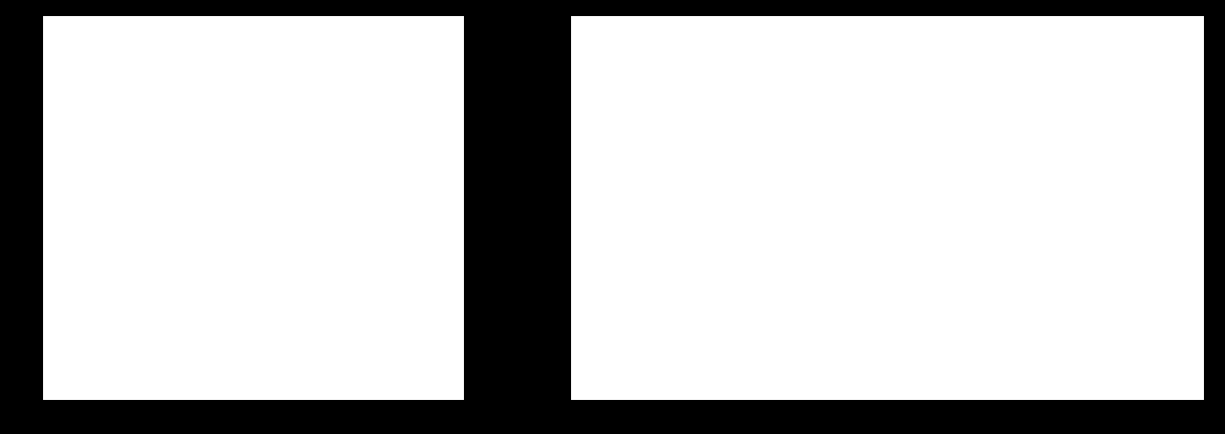

In [10]:
import matplotlib as mpl
import tqdm

for data in train_dataloader:   
    1
    
s_t = None
blue = 'blue'

pink = '#F601FF'


model.cuda()
data.cuda()
clip = (data.x.float()  - 
            data.x.float().mean(2, keepdim=True))/(data.x.float().std(2, keepdim=True) +1e-10)

signal = sio.loadmat('/home/data_shared/signal_eeg.mat')['signal'][19:2*19,:]

signal = signal+ 0.0004*np.arange(0,19).reshape(-1,1)

signal = signal.T


gt = np.zeros(signal.shape)
gt[1400:2000,:] = 1
seiz = [float('nan') if x==0 else x for x in np.ravel(gt*signal) ]
seiz = np.array(seiz).reshape(2000,19)

index = 0
nc_before = 0

for t in tqdm.tqdm(range(10)):
    N = 5
    for i in range( N ):
        
        x_t = clip[:,t,:].float()
        s_t  = model.update(x_t ,data.edge_index , data.edge_weight , s_t , fire_rate = 0.5)
        nc = torch.sigmoid(model.fc(s_t)).cpu().detach().numpy()[19:19*2]
        
        for j in range(4):

            fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 3]} , figsize=(15,5) , facecolor='k')
            
            index = index+1

            color_node = nc_before+ j*(- nc_before + nc)/3
            
            draw_graph_weighted_edge(adj_mx, axs[0],
            node_id_dict,
            pos_spec,
            is_directed=True,
            title='',
            save_dir='Desktop',
            fig_size=(
                3,
                3),
            node_color = torch.sigmoid(model.fc(s_t)).cpu().detach().numpy()[19:19*2],
            font_size=15,
                plot_colorbar=False )
    
    
            axs[1].plot(signal[0:10*index,:] , lw = 2 , color = 'cyan' , label = ['Normal',None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None])
            axs[1].plot(seiz[0:10*index,:] , lw = 2 , color = pink ,label = ['Seizure',None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None])

            axs[1].set_xlim([0,2000])
            axs[1].set_ylim([-0.0003,0.008])

            axs[1].legend( fontsize=15 , loc = 4)

            axs[1].axis('off')

            axs[0].axis('off')

            # Seizure colorbar
            cmap = plt.cm.cool(np.linspace(0, 1, (0 + 1) * 190))
            cmap = matplotlib.colors.ListedColormap(cmap)
            
            sm = plt.cm.ScalarMappable(
                        cmap=cmap, norm=plt.Normalize(
                            vmin=0, vmax=1))
            # sm.set_array([])
            plt.style.use("dark_background")
            cbar = plt.colorbar( sm , ax=axs[0] , location='left' , aspect=12  )
            cbar.ax.tick_params(labelsize=15)
            cbar.set_label('Node Seiz Probability \n' , fontsize = 20)
            
    
            nc_before = nc
            plt.savefig('images_rest/' + str(index) + '.png' , dpi=300)
    

## Make GIf


In [22]:
import imageio
import glob
import cv2
import tqdm

frames = []

for index in tqdm.tqdm(range(200)):
    
    img = plt.imread('images_rest/'+ str(index+1)+ '.png')
    frames.append((255*img[:,:,0:3]).astype(np.uint8))
  

100%|█████████████████████████████████████████| 200/200 [00:50<00:00,  3.98it/s]


In [23]:
import imageio
imageio.mimsave('rest_egg_new.mp4', # output gif
                frames,          # array of input frames
                fps = 10) 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (4500, 1500) to (4512, 1504) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x680b480] Warning: data is not aligned! This can lead to a speed loss


In [20]:
import numpy as np
import os
import sys
import pickle
import graph_viz_utils
from graph_viz_utils import get_spectral_graph_positions
import networkx as nx
import collections
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import pickle
from graph_viz_utils import draw_graph_weighted_edge

with open('adj_mx_3d.pkl', 'rb') as pf:
    adj_mx_data = pickle.load(pf)

adj_mx = adj_mx_data[2]
adj_mx.shape

(19, 19)

In [21]:
def draw_graph_weighted_edge(
        adj_mx,
        node_id_dict,
        pos_spec,
        is_directed=True,
        title='',
        save_dir=None,
        fig_size=(
            12,
            8),
    node_color='Red',
    font_size=20,
        plot_colorbar=False):
    """
    Draw a graph with weighted edges
    Args:
        adj_mx: Adjacency matrix for the graph, shape (num_nodes, num_nodes
        node_id_dict: dict, key is node name, value is node index
        pos_spec: Graph node position specs from function get_spectral_graph_positions
        is_directed: If True, draw directed graphs
        title: str, title of the figure
        save_dir: Dir to save the plot
        fig_size: figure size

    """
    eeg_viz = nx.DiGraph() if is_directed else nx.Graph()
    node_id_label = collections.defaultdict()

    for i in range(adj_mx.shape[0]):
        eeg_viz.add_node(i)

    for k, v in node_id_dict.items():
        node_id_label[v] = k

    # Add edges
    for i in range(adj_mx.shape[0]):
        for j in range(adj_mx.shape[1]):  # since it's now directed
            if i != j and adj_mx[i, j] > 0:
                eeg_viz.add_edge(i, j, weight=adj_mx[i, j])

    edges, weights = zip(*nx.get_edge_attributes(eeg_viz, 'weight').items())

    # Change the color scales below
    k = 3
    cmap = plt.cm.binary(np.linspace(0, 1, (k + 1) * len(weights)))
    cmap = matplotlib.colors.ListedColormap(cmap[len(weights):-1:(k - 1)])

    cmap_node = plt.cm.cool(np.linspace(0, 1, (0 + 1) * 19))
    cmap_node = matplotlib.colors.ListedColormap(cmap_node)

    
    # cmap_node = matplotlib.colors.ListedColormap(cmap_node[len(weights):-1:(k - 1)])

    plt.figure(figsize=fig_size)
    
    nx.draw_networkx(eeg_viz, pos_spec, labels=node_id_label, with_labels=True,arrows=False,
                     edgelist=edges, edge_color=rankdata(weights), 
                     width=3*fig_size[1] / 2, edge_cmap=cmap, font_weight='bold',
                     node_color=node_color,
                     cmap = cmap_node,
                     node_size=250 * (fig_size[0] + fig_size[1]),
                     font_color='white',
                     font_size=font_size)
    plt.title(title, fontsize=font_size)
    plt.axis('off')
    if plot_colorbar:
        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(
                vmin=0, vmax=1))
        sm.set_array([])
        plt.colorbar(sm)
    plt.tight_layout()
    if save_dir is not None:
        plt.savefig(save_dir, dpi=300 , transparent=True)

    plt.show()


In [22]:
node_id_dict = {}
for key, val in adj_mx_data[1].items():
    key = key.split(' ')[-1]
    node_id_dict[key] = val

pos_spec = get_spectral_graph_positions()


In [14]:
from matplotlib.colors import LinearSegmentedColormap

k=3

cm = plt.cm.cool(np.linspace(0, 1, (k + 1) * 100))
# cm = LinearSegmentedColormap.from_list(
#         "Custom", colors, N=20)

#     print(x[19*s:19*(s+1),199])




draw_graph_weighted_edge(adj_mx, ax,
        node_id_dict,
        pos_spec,
        is_directed=True,
        title='',
        save_dir='Desktop',
        fig_size=(
            8,
            8),
    node_color = torch.sigmoid(model.fc(s_t)).cpu().detach().numpy()[19:19*2],
    font_size=20,
        plot_colorbar=False )

k = 3
plt.cm.Oranges(np.linspace(0, 1, (k + 1) * 19))
cmap = plt.cm.Oranges(np.linspace(0, 1, 100 ))
cmap = matplotlib.colors.ListedColormap(cmap[19:-1:(k - 1)])
import matplotlib as mpl


fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

norm = mpl.colors.Normalize(vmin=5, vmax=10)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap) , cax=ax, orientation='horizontal', label='Some Units')


NameError: name 'ax' is not defined

In [216]:
signal = data.x[22,:,:].reshape(-1,1)
from scipy.io import savemat
import numpy as np
mdic = {"signal": signal, "label": "signal"}

savemat("data_eeg.mat", mdic)

In [208]:
import imageio
import glob
import cv2
import tqdm

frames = []

for index in tqdm.tqdm(range(1962)):
    
    img = plt.imread('signal_electrode/'+ str(index)+ '.png')
    frames.append((255*img[:,:,0:3]).astype(np.uint8))
  

100%|███████████████████████████████████████| 1962/1962 [03:37<00:00,  9.01it/s]


In [213]:
imageio.mimsave('rest_elecl_sig.gif', # output gif
                frames,          # array of input frames
                fps = 225) 

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation
import time as T

In [18]:
data.x.shape
out = model.to('cuda')(data.to('cuda'))
out = global_mean_pool (out , data.batch)
torch.sigmoid(out.reshape(-1,1)) 

tensor([[9.9481e-01],
        [2.2097e-01],
        [1.8165e-01],
        [4.0505e-01],
        [2.2266e-01],
        [8.7604e-01],
        [9.3119e-01],
        [5.0994e-02],
        [9.2078e-01],
        [5.3878e-02],
        [8.7425e-01],
        [9.9465e-01],
        [2.1453e-01],
        [9.8334e-01],
        [9.8308e-01],
        [9.7537e-01],
        [3.6222e-02],
        [9.8076e-01],
        [9.9172e-01],
        [1.2816e-01],
        [9.2793e-01],
        [9.1909e-01],
        [2.9979e-01],
        [1.2005e-01],
        [1.7931e-02],
        [9.2438e-01],
        [9.1921e-02],
        [1.8959e-01],
        [7.4432e-02],
        [9.9849e-01],
        [4.8742e-01],
        [8.3741e-01],
        [9.3581e-01],
        [6.5802e-01],
        [1.1191e-01],
        [6.7333e-01],
        [9.8699e-01],
        [6.2104e-02],
        [9.4324e-01],
        [5.3030e-01],
        [6.3019e-01],
        [8.1337e-01],
        [5.4254e-02],
        [9.7551e-01],
        [1.2625e-01],
        [9

In [31]:
def draw_graph_weighted_edge(
        adj_mx,
        ax,
        node_id_dict,
        pos_spec,
        is_directed=True,
        title='',
        save_dir=None,
        fig_size=(
            12,
            8),
    node_color='Red',
    font_size=20,
        plot_colorbar=False):
    """
    Draw a graph with weighted edges
    Args:
        adj_mx: Adjacency matrix for the graph, shape (num_nodes, num_nodes
        node_id_dict: dict, key is node name, value is node index
        pos_spec: Graph node position specs from function get_spectral_graph_positions
        is_directed: If True, draw directed graphs
        title: str, title of the figure
        save_dir: Dir to save the plot
        fig_size: figure size

    """
    eeg_viz = nx.DiGraph() if is_directed else nx.Graph()
    node_id_label = collections.defaultdict()

    for i in range(adj_mx.shape[0]):
        eeg_viz.add_node(i)

    for k, v in node_id_dict.items():
        node_id_label[v] = k

    # Add edges
    for i in range(adj_mx.shape[0]):
        for j in range(adj_mx.shape[1]):  # since it's now directed
            if i != j and adj_mx[i, j] > 0:
                eeg_viz.add_edge(i, j, weight=adj_mx[i, j])

    edges, weights = zip(*nx.get_edge_attributes(eeg_viz, 'weight').items())

    # Change the color scales below
    k = 3
    cmap = plt.cm.binary(np.linspace(-2, 1, (k + 1) * len(weights)))
    cmap = matplotlib.colors.ListedColormap(cmap[len(weights):-1:(k - 1)])

    cmap_node = plt.cm.cool(np.linspace(0, 1, (0 + 1) * 19))
    cmap_node = matplotlib.colors.ListedColormap(cmap_node)

    
    # cmap_node = matplotlib.colors.ListedColormap(cmap_node[len(weights):-1:(k - 1)])

    
    
    nx.draw_networkx(eeg_viz, pos_spec, labels=node_id_label, with_labels=True,arrows=False,ax=ax,
                     edgelist=edges, edge_color=rankdata(weights), 
                     width=3*fig_size[1] / 2, edge_cmap=cmap, font_weight='bold',
                     node_color=node_color,
                     cmap = cmap_node,
                     node_size=250 * (fig_size[0] + fig_size[1]),
                     font_color='white',
                     font_size=font_size)
    ax.set_title(title, fontsize=font_size)
    # plt.axis('off')
    if plot_colorbar:
        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(
                vmin=0, vmax=1))
        sm.set_array([])
        plt.colorbar(sm , ax)
    plt.tight_layout()
    if save_dir is not None:
        plt.savefig(save_dir, dpi=300 , transparent=True)

    # plt.show()


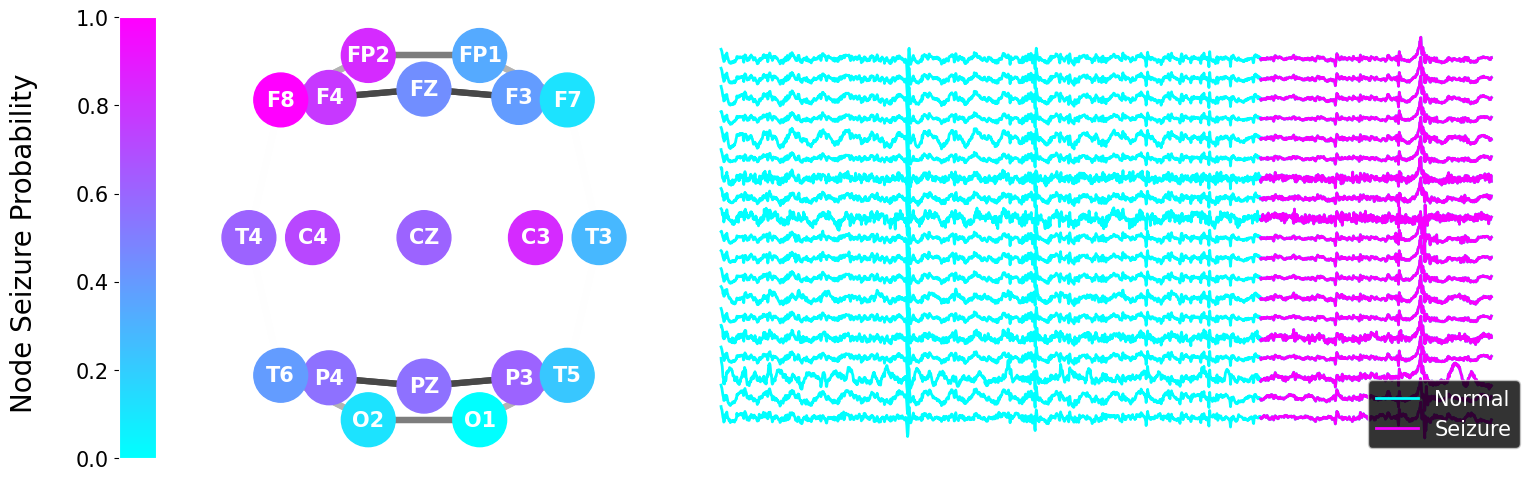

In [49]:
from matplotlib.colors import LinearSegmentedColormap

signal = sio.loadmat('signal_eeg.mat')['signal'][19:2*19,:]

signal = signal+ 0.0004*np.arange(0,19).reshape(-1,1)

signal = signal.T

k=3
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 3]} , figsize=(15,5) , facecolor='w')

cm = plt.cm.cool(np.linspace(0, 1, (k + 1) * 100))

gt = np.zeros(signal.shape)
gt[1400:2000,:] = 1
seiz = [float('nan') if x==0 else x for x in np.ravel(gt*signal) ]
seiz = np.array(seiz).reshape(2000,19)


draw_graph_weighted_edge(adj_mx, axs[0],
        node_id_dict,
        pos_spec,
        is_directed=True,
        title='',
        save_dir='Desktop',
        fig_size=(
            3,
            3),
    node_color = torch.sigmoid(model.fc(s_t)).cpu().detach().numpy()[19:19*2],
    font_size=15,
        plot_colorbar=False )

label = np.ones((1,19))
axs[1].plot(signal, lw=2 , color = 'cyan' , label = ['Normal',None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None])
axs[1].plot(seiz , lw=2 , color = pink , label = ['Seizure',None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None])

axs[1].legend(fontsize=15 , loc = 4)

axs[1].axis('off')

axs[0].axis('off')

cmap = plt.cm.cool(np.linspace(0, 1, (0 + 1) * 190))
cmap = matplotlib.colors.ListedColormap(cmap)

sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(
                vmin=0, vmax=1))
# sm.set_array([])
# plt.style.use("dark_background")
cbar = plt.colorbar( sm , ax=axs[0] , location='left' , aspect=12  )
cbar.ax.tick_params(labelsize=15 , color = 'k' )
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k')
cbar.set_label('Node Seizure Probability \n' , fontsize = 20 , color = 'k')


In [74]:
signal.shape , gt.shape , (gt*signal).shape , np.array(seiz).reshape(2000,19).shape

((2000, 19), (2000, 19), (2000, 19), (2000, 19))